In [797]:
import torch
from torch import (optim, nn)

from torch.utils.data import (
    DataLoader,
    TensorDataset,
    random_split
)

import numpy as np

# User-defined classes
from utils.base import (
    # LinearRegression,
    LogisticRegression,
    Trainer
)

# Plotting
import matplotlib.pyplot as plt

plt.style.use("seaborn-v0_8")
plt.rcParams["font.family"] = "monospace"

In [798]:
# Constants
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
DTYPE = torch.float32
BATCH_SIZE = 32
NUM_EPOCHS = 50
SIZE = 100
GENERATOR = torch.Generator().manual_seed(42)

print(f"Device has ben set to: {torch.cuda.get_device_properties(DEVICE).name}")

Device has ben set to: NVIDIA GeForce RTX 4060 Laptop GPU


In [799]:
T = torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')

X0 = .8 * T + 3 + torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')
X1 = T - .3 + torch.randn(SIZE, 1, dtype=DTYPE, generator=GENERATOR, device='cpu')

X = torch.tensor(np.concatenate([X0, X1], dtype=np.float32, axis=1))

W = torch.randn(2, dtype=DTYPE, device='cpu')
b = torch.randn(1, dtype=DTYPE, device='cpu')

y = X @ W + b

In [800]:
print("Generated X:", X, "\nGenerated y:", y, sep='\n')

Generated X:
tensor([[ 5.2677,  1.1658],
        [ 4.2810,  1.1234],
        [ 3.3315, -0.7660],
        [ 1.8435, -2.0757],
        [ 4.5738, -0.6043],
        [ 1.3076, -1.2328],
        [ 3.9787, -0.1644],
        [ 1.3854, -2.0340],
        [ 3.4933, -2.6275],
        [ 4.6589,  3.5996],
        [ 3.4060,  0.3088],
        [ 2.2885, -0.3394],
        [ 1.8444, -0.3946],
        [ 3.0593, -0.4544],
        [ 1.9097, -0.7272],
        [ 3.1179,  0.2411],
        [ 4.1778,  1.5152],
        [ 4.5077,  0.5918],
        [ 3.2568, -0.7899],
        [ 3.9277,  0.0622],
        [ 2.0326, -0.4154],
        [ 3.8021,  1.3526],
        [ 3.7139,  1.0875],
        [ 5.1631,  1.3618],
        [ 3.6480,  0.0648],
        [ 5.0702,  2.4804],
        [ 2.8017, -0.6004],
        [ 4.7046,  0.5056],
        [ 3.0323, -1.3368],
        [ 2.9868,  0.2576],
        [ 1.3652, -1.2645],
        [ 3.1214,  0.7795],
        [ 2.1617, -1.1212],
        [ 2.0926,  0.6870],
        [ 2.0885,  0.5207],
       

In [801]:
print("Generated Parameters:", "Weights: {}".format(W), "Bias: {}".format(b), sep='\n')

Generated Parameters:
Weights: tensor([-0.7812, -0.6379])
Bias: tensor([-0.4333])


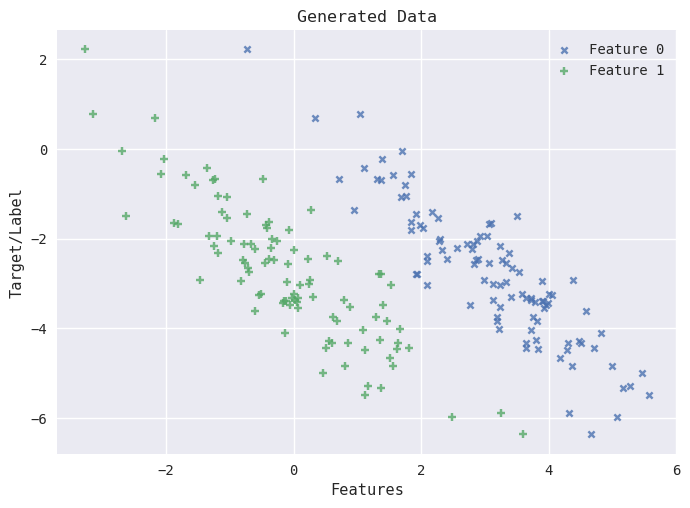

In [802]:
plt.scatter(X[:, 0].numpy(), y.numpy(), label="Feature 0", marker='x', alpha=.8, s=20);
plt.scatter(X[:, 1].numpy(), y.numpy(), label="Feature 1", marker='+', alpha=.8, s=40);
plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();

In [757]:
# Transforming y to get logits
probs = torch.sigmoid(y)
print("Probs:", probs, sep='\n')

Probs:
tensor([0.3526, 0.3247, 0.8807, 0.9074, 0.8144, 0.8249, 0.5897, 0.9298, 0.9799,
        0.0097, 0.3619, 0.4797, 0.6195, 0.6407, 0.7285, 0.5789, 0.2229, 0.2744,
        0.7571, 0.5790, 0.6186, 0.2109, 0.2559, 0.2552, 0.7080, 0.0430, 0.8314,
        0.5292, 0.9007, 0.4592, 0.9032, 0.3822, 0.7674, 0.2044, 0.3380, 0.5769,
        0.2571, 0.8427, 0.5429, 0.7877, 0.9918, 0.9384, 0.8811, 0.4939, 0.7681,
        0.2658, 0.9905, 0.7650, 0.5569, 0.9158, 0.9053, 0.6484, 0.4582, 0.1246,
        0.8351, 0.6923, 0.9550, 0.5214, 0.5184, 0.2046, 0.5760, 0.2218, 0.9082,
        0.0146, 0.1778, 0.1703, 0.2642, 0.7669, 0.7628, 0.9095, 0.6283, 0.4051,
        0.5563, 0.7463, 0.3110, 0.7809, 0.1893, 0.8619, 0.9616, 0.9335, 0.6125,
        0.9521, 0.2801, 0.7471, 0.6677, 0.6441, 0.3635, 0.6001, 0.4865, 0.4087,
        0.3072, 0.7490, 0.5518, 0.2646, 0.1353, 0.6911, 0.6662, 0.1147, 0.6070,
        0.1680])


In [758]:
yb = (y > .5).type(DTYPE)       # Decision Boundary
print("New values for y:", yb, sep='\n')

New values for y:
tensor([0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0.,
        1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 1., 0., 1., 0., 1., 0., 0., 0.,
        0., 1., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0.,
        1., 1., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
        0., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 0., 0.,
        0., 1., 0., 0., 0., 1., 1., 0., 0., 0.])


In [759]:
print("# of instances at each class (for 0 and 1)")
print("0: {}".format(yb[yb == 0].numel()), "1: {}".format(yb[yb == 1].numel()), sep='\n')

# of instances at each class (for 0 and 1)
0: 55
1: 45


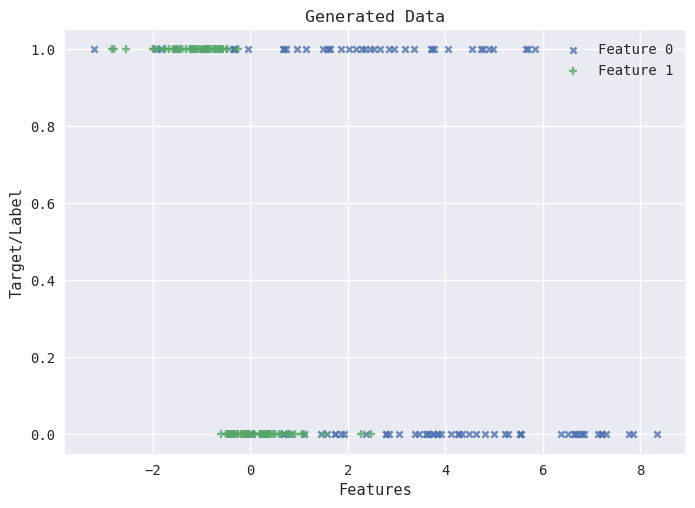

In [760]:
plt.scatter(X[:, 0].numpy(), yb.numpy(), label="Feature 0", marker='x', alpha=.8, s=20);
plt.scatter(X[:, 1].numpy(), yb.numpy(), label="Feature 1", marker='+', alpha=.8, s=40);
plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();

In [608]:
Model = LogisticRegression(in_dims=2).to(DEVICE)

In [609]:
Data = TensorDataset(X, yb)
Data.tensors

(tensor([[ 5.2677,  1.1658],
         [ 4.2810,  1.1234],
         [ 3.3315, -0.7660],
         [ 1.8435, -2.0757],
         [ 4.5738, -0.6043],
         [ 1.3076, -1.2328],
         [ 3.9787, -0.1644],
         [ 1.3854, -2.0340],
         [ 3.4933, -2.6275],
         [ 4.6589,  3.5996],
         [ 3.4060,  0.3088],
         [ 2.2885, -0.3394],
         [ 1.8444, -0.3946],
         [ 3.0593, -0.4544],
         [ 1.9097, -0.7272],
         [ 3.1179,  0.2411],
         [ 4.1778,  1.5152],
         [ 4.5077,  0.5918],
         [ 3.2568, -0.7899],
         [ 3.9277,  0.0622],
         [ 2.0326, -0.4154],
         [ 3.8021,  1.3526],
         [ 3.7139,  1.0875],
         [ 5.1631,  1.3618],
         [ 3.6480,  0.0648],
         [ 5.0702,  2.4804],
         [ 2.8017, -0.6004],
         [ 4.7046,  0.5056],
         [ 3.0323, -1.3368],
         [ 2.9868,  0.2576],
         [ 1.3652, -1.2645],
         [ 3.1214,  0.7795],
         [ 2.1617, -1.1212],
         [ 2.0926,  0.6870],
         [ 2.0

In [610]:
trainData, valData = random_split(Data, (0.8, 0.2), generator=GENERATOR)

trainLoader = DataLoader(trainData, batch_size=BATCH_SIZE, shuffle=True)
valLoader = DataLoader(valData, batch_size=BATCH_SIZE, shuffle=True)

In [611]:
trainer = Trainer(
    Model,
    trainLoader,
    valLoader,
    optimizer=optim.SGD(Model.parameters(), lr=.1),
    criterion=nn.BCELoss(reduction='mean'),        # Binary Cross-entropy Loss (For classification)
    device=DEVICE
)

In [612]:
train_loss, val_loss = trainer.train(num_epochs=NUM_EPOCHS)

	Epoch 1 | Weights: tensor([-1.6890, -0.1450], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.5198], device='cuda:0')
	Epoch 1 | Weights: tensor([-1.5868, -0.1089], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.4939], device='cuda:0')
	Epoch 1 | Weights: tensor([-1.4339, -0.0552], device='cuda:0')
	Epoch 1 | Bias: tensor([-0.4510], device='cuda:0')
Epoch 1/50 | Loss: 2.6741
	| Validation Loss: 1.0779

	Epoch 2 | Weights: tensor([-1.3363, -0.0168], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.4259], device='cuda:0')
	Epoch 2 | Weights: tensor([-1.1602,  0.0417], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.3841], device='cuda:0')
	Epoch 2 | Weights: tensor([-1.0461,  0.0991], device='cuda:0')
	Epoch 2 | Bias: tensor([-0.3561], device='cuda:0')
Epoch 2/50 | Loss: 1.9290
	| Validation Loss: 0.7927

	Epoch 3 | Weights: tensor([-0.8780,  0.1641], device='cuda:0')
	Epoch 3 | Bias: tensor([-0.3138], device='cuda:0')
	Epoch 3 | Weights: tensor([-0.7676,  0.2069], device='cuda:0')
	Epoch 3 | Bias:

In [613]:
print("Train Loss:", train_loss, "\nValidation Loss:", val_loss, sep='\n')

Train Loss:
{0: 2.67405370871226, 1: 1.9289699792861938, 2: 1.297000487645467, 3: 0.8969244559605917, 4: 0.6072918176651001, 5: 0.4638287127017975, 6: 0.4429282645384471, 7: 0.41583697001139325, 8: 0.4024947981039683, 9: 0.3874039947986603, 10: 0.3739423255125682, 11: 0.35767093300819397, 12: 0.34389912088712055, 13: 0.34074950218200684, 14: 0.31583357850710553, 15: 0.32869304219881695, 16: 0.30721530318260193, 17: 0.3046315312385559, 18: 0.29904748996098834, 19: 0.288324495156606, 20: 0.27184806764125824, 21: 0.27267037332057953, 22: 0.2890353898207347, 23: 0.2620244324207306, 24: 0.2629832923412323, 25: 0.2624899546305339, 26: 0.2588614573081334, 27: 0.24251319468021393, 28: 0.245594784617424, 29: 0.22916769484678903, 30: 0.24941272040208182, 31: 0.23284023503462473, 32: 0.2436593919992447, 33: 0.2450850854317347, 34: 0.22170222798983255, 35: 0.22937795519828796, 36: 0.23559945821762085, 37: 0.23133943478266397, 38: 0.21664275228977203, 39: 0.21569984157880148, 40: 0.2175643940766652

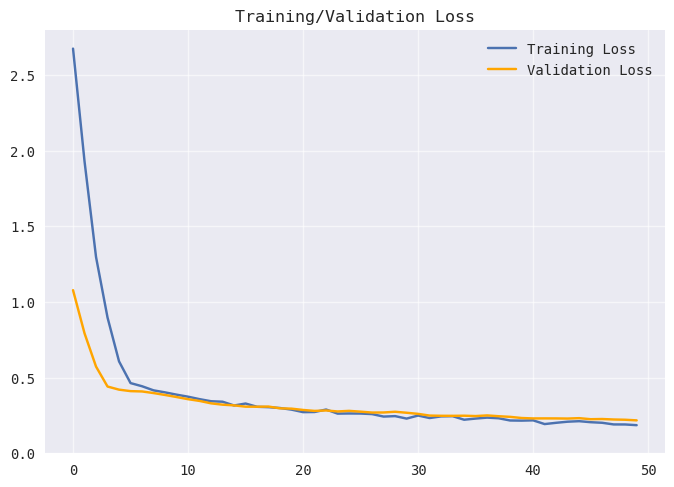

In [614]:
plt.plot(
    train_loss.keys(),
    train_loss.values(),
    label="Training Loss"
);
plt.plot(
    val_loss.keys(),
    val_loss.values(),
    color="orange",
    label="Validation Loss"
);
plt.ylim(bottom=0)
plt.grid(True, alpha = .6);
plt.title("Training/Validation Loss");
plt.legend(loc='best');
plt.show()

In [615]:
print(f"Predicted Model Parameters:", "Weights: {}".format(Model.w), "Bias: {}".format(Model.b), sep="\n")
# Generated Parameters:
# Weights: tensor([ 0.8041, -1.8572])
# Bias: tensor([-0.4053])

Predicted Model Parameters:
Weights: Parameter containing:
tensor([-0.1166,  2.2145], device='cuda:0', requires_grad=True)
Bias: Parameter containing:
tensor([-0.6600], device='cuda:0', requires_grad=True)


In [616]:
T = torch.tensor(np.linspace(X.min(), X.max(), SIZE).reshape(SIZE, 1), dtype=DTYPE, device=DEVICE)
T = torch.cat([T, T], dim=1)

with torch.no_grad():
    yT = Model(T)

print("Tensor T to plot the boundary:", T, sep='\n')
print("Results:", yT.float(), sep='\n')

Tensor T to plot the boundary:
tensor([[-3.2704, -3.2704],
        [-3.1812, -3.1812],
        [-3.0919, -3.0919],
        [-3.0026, -3.0026],
        [-2.9134, -2.9134],
        [-2.8241, -2.8241],
        [-2.7348, -2.7348],
        [-2.6456, -2.6456],
        [-2.5563, -2.5563],
        [-2.4670, -2.4670],
        [-2.3778, -2.3778],
        [-2.2885, -2.2885],
        [-2.1992, -2.1992],
        [-2.1100, -2.1100],
        [-2.0207, -2.0207],
        [-1.9314, -1.9314],
        [-1.8422, -1.8422],
        [-1.7529, -1.7529],
        [-1.6636, -1.6636],
        [-1.5744, -1.5744],
        [-1.4851, -1.4851],
        [-1.3958, -1.3958],
        [-1.3066, -1.3066],
        [-1.2173, -1.2173],
        [-1.1280, -1.1280],
        [-1.0388, -1.0388],
        [-0.9495, -0.9495],
        [-0.8602, -0.8602],
        [-0.7710, -0.7710],
        [-0.6817, -0.6817],
        [-0.5924, -0.5924],
        [-0.5032, -0.5032],
        [-0.4139, -0.4139],
        [-0.3246, -0.3246],
        [-0.2354,

In [617]:
X0 = X[yb == 0]
X1 = X[yb == 1]

X0.size(), X1.size()

(torch.Size([69, 2]), torch.Size([31, 2]))

In [618]:
y[yb == 0].size()

torch.Size([69])

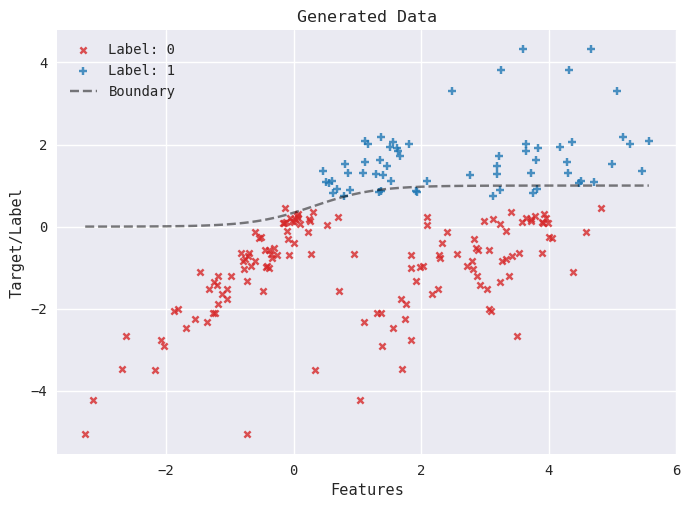

In [619]:
plt.scatter(X0[:, 0].numpy(), y[yb == 0].numpy(), label="Label: 0", marker='x', alpha=.8, c='#d62728', s=20);
plt.scatter(X1[:, 0].numpy(), y[yb == 1].numpy(), label="Label: 1", marker='+', alpha=.8, c='#1f77b4', s=40);

plt.scatter(X0[:, 1].numpy(), y[yb == 0].numpy(), marker='x', c='#d62728', alpha=.8, s=20);
plt.scatter(X1[:, 1].numpy(), y[yb == 1].numpy(), marker='+', alpha=.8, c='#1f77b4', s=40);
# Decision Boundary
plt.plot(
    T[:, 1].cpu(),
    yT.cpu(),
    alpha=.5,
    color='black',
    linestyle='--',
    label="Boundary"
);

plt.xlabel("Features");
plt.ylabel("Target/Label");
plt.title("Generated Data");
plt.legend(loc='best');
plt.show();